### Property Description Words

In [1]:
import platform
from datetime import date

import dtale
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyodbc
import scipy.stats
import seaborn as sns
import sweetviz
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL

# import pandas_profiling


pd.set_option("display.max_columns", None)

In [2]:
import os

# Change the current working directory
os.chdir(
    "C:/Users/DeepankarSrigyan/OneDrive - Sykes Cottages Ltd/Desktop/Project/Property Description/"
)

In [3]:
def fetch_SQLserver_data(sql_code, conn_string):
    """
    Uses pyodbc.connect and pandas.read_sql to return query results as dataframe.
    :param sql_code: string, query to be submitted
    :param conn_string: string, full connection details as string
    """
    connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": conn_string})
    engine = create_engine(connection_url)
    with engine.connect() as conn:
        df = pd.read_sql(sql=text(sql_code), con=conn)
        conn.commit()
    print("Data Imported")
    return df


if platform.system() == "Windows":
    conn_CDM = "DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-04;DATABASE=CDM;trusted_connection=Yes"
    conn_l0 = "DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-04;DATABASE=Sykes_DW_Level0_Staging;trusted_connection=Yes"
    conn_l2 = "DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-04;DATABASE=Sykes_DW_Level2_ADM;trusted_connection=Yes"
    conn_BOX = "DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-04;DATABASE=Box;trusted_connection=Yes"

    print("Connection Completed")

Connection Completed


In [4]:
def convert_date_column(df, column_name):
    """
    Converts a date column in a DataFrame from string (object) to datetime.

    Args:
    df (pd.DataFrame): The DataFrame containing the date column.
    column_name (str): The name of the column to convert.

    Returns:
    pd.DataFrame: A DataFrame with the date column converted to datetime.
    """
    df[column_name] = pd.to_datetime(df[column_name], format="%Y-%m-%d")
    return df

In [6]:
raw_property_view = fetch_SQLserver_data(
    """
with property AS(
SELECT
    p.propertyid,
    p.propertyreference,
    p.propertylivedate,
    p.DateToldWithdrawingLocal,
    p.bedrooms,
    p.propertyType,
    p.sleeps,
    p.location,
    RANK() OVER (
        PARTITION BY p.propertyreference
        ORDER BY d.valid_to DESC
    ) AS property_rank,
    case when p.DateToldWithdrawingLocal is null then 0 else 1 end as churn,
    d.*
FROM
    CDM.propertymanagement.Property p
    LEFT JOIN
    [Sykes_DW_Level0_Staging].[YMIR_toms].[property_description] d
    ON p.PropertyReference = d._fk_property
WHERE 
    p.propertylivedate >= '2020-01-01'
    AND p.PropertyLiveDate IS NOT NULL
    AND d.valid_from IS NOT NULL
    AND (
        p.PropertyLiveDate >= d.valid_from
    AND p.PropertyLiveDate <= COALESCE(d.valid_to, CAST(GETDATE() AS DATE))
    )
    
-- ORDER BY 
--     p.PropertyReference
)
select * from property where property_rank=1


""",
    conn_CDM,
)
raw_property_view

Data Imported


,propertyid,propertyreference,propertylivedate,DateToldWithdrawingLocal,bedrooms,propertyType,sleeps,location,property_rank,churn,__pk,_fk_property,valid_from,valid_to,property_characteristics_building,property_characteristics_location,property_characteristics_policy,property_characteristics_entertainment,property_characteristics_landing_page,property_characteristics_facilities,details_general,details_accomodation,details_amenities,short_description,language,purpose,details_directions,wd_general_details,wd_accom_details,wd_ammenities_details,brochure_description,bd_general_details,bd_accom_details,bd_ammenities_details,tpd_region_description,tpd_town_description,tpd_home_summary,tpd_home_description,tpd_cottage_name_30,tpd_cottage_name_100,tpd_lte_home_summary,tpd_exterior_facilities,tpd_interior_facilities,tpd_rental_details,tpd_special_conditions,rd_gen_keywords,rd_gen_property_description,rd_gen_general,rd_inside_floor_title,rd_inside_floor,rd_inside_floor_title_2,rd_inside_floor_2,rd_inside_floor_title_3,rd_inside_floor_3,rd_inside_floor_title_4,rd_inside_floor_4,rd_inside_floor_title_5,rd_inside_floor_5,rd_inside_floor_title_6,rd_inside_floor_6,rd_inside_floor_title_7,rd_inside_floor_7,rd_outside,rd_notes,rd_area_drivingtimes,rd_area_nearestshop,rd_area_nearestpub,rd_area_nearestvillage,rd_area_nearesttown,rd_area_nearestbeach,rd_area_doorstep,rd_area_daytrip,rd_descriptionlive,rd_descriptionbrand,time_createdutc,wd_general_details_html,wd_accom_details_html,wd_ammenities_details_html,tripadvisor_village,tripadvisor_subregion,tripadvisor_region,tripadvisor_country,tripadvisor_title,short_description_intro,short_description_full,short_description_proofread,short_description_proofread_user,medium_description_intro,medium_description_full,medium_description_proofread,medium_description_proofread_user,long_description_intro,long_description_full,long_description_proofread,long_description_proofread_user,acquisition_short_description,acquisition_long_description,access_statement,strapline,last_updatedutc
0,50037,2074,2023-05-09,None,3,Terraced,5.0,Pentre Hodre,1,0,39740,2074.0,2013-11-12,2033-11-12,None,None,None,None,Landing Page - Gay/Lesbian\rLanding Page - Enc...,,A stunning barn conversion on the outskirts of...,Three bedrooms: 1 x double with en-suite showe...,Oil central heating with electric fire in sitt...,Superb Grade II listed barn conversion 2 miles...,None,Filemaker Import,From the A4113 enter Brampton Bryan continue o...,A stunning barn conversion on the outskirts of...,Three bedrooms: 1 x double with en-suite showe...,"Electric oven & hob, microwave, fridge/freezer...",None,None,None,None,"A E Houseman once wrote that Shropshire was ""t...",The pretty village of Bucknell nestles in the ...,The picturesque village of Bucknell has a trai...,Swallow Cottage is a magnificent barn conversi...,Swallow Cottage,"Swallow Cottage, Heart Of England",The picturesque village of Bucknell has a trai...,,,,,,A bonnie farm building on the border of Buckne...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,,None,,,,,,,None,None,No,None,2013-11-12 05:07:21,A stunning barn conversion on the outskirts of...,Three bedrooms: 1 x double with en-suite showe...,Oil central heating with electric fire in sitt...,Bucknell,Shropshire,Heart of England,England,"SWALLOW COTTAGE, family friendly, luxury holid...","An exceptional, semi-detached 18th century Gra...",Swallow Cottage retains a wealth of original f...,1,carly.jones,"An exceptional, semi-detached 18th century Gra...","Renovated to a high standard, Swallow Cottage ...",1,carly.jones,"An exceptional, semi-detached, stone-built, 18...","Renovated to a very high standard, Swallow Cot...",1,carly.jones,None,None,None,None,2023-12-22 12:13:24
1,127056,917853,2020-02-26,2023-01-25,3,House semi-detached,6.0,Craig-y-penrhyn,1,1,50261,917853.0,2016-09-13,None,None,None,None,None,None,,None,None,None,A welcoming base from which to discover the co...,None,None,None,Boas

In [22]:
def add_word_count_columns(df):
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df_copy = df.copy()
    
    for col in df_copy.columns:
        # Create new column name
        new_col_name = f'WordCount_{col}'
        # Calculate the number of words in each value in the column
        df_copy.loc[:, new_col_name] = df_copy[col].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
    
    return df_copy

# Example usage

desc_with_word_counts = add_word_count_columns(raw_property_view)
desc_with_word_counts

C:\Users\DeepankarSrigyan\AppData\Local\Temp\ipykernel_5728\630051088.py:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\DeepankarSrigyan\AppData\Local\Temp\ipykernel_5728\630051088.py:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\DeepankarSrigyan\AppData\Local\Temp\ipykernel_5728\630051088.py:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

,propertyid,propertyreference,propertylivedate,DateToldWithdrawingLocal,bedrooms,propertyType,sleeps,location,property_rank,churn,__pk,_fk_property,valid_from,valid_to,property_characteristics_building,property_characteristics_location,property_characteristics_policy,property_characteristics_entertainment,property_characteristics_landing_page,property_characteristics_facilities,details_general,details_accomodation,details_amenities,short_description,language,purpose,details_directions,wd_general_details,wd_accom_details,wd_ammenities_details,brochure_description,bd_general_details,bd_accom_details,bd_ammenities_details,tpd_region_description,tpd_town_description,tpd_home_summary,tpd_home_description,tpd_cottage_name_30,tpd_cottage_name_100,tpd_lte_home_summary,tpd_exterior_facilities,tpd_interior_facilities,tpd_rental_details,tpd_special_conditions,rd_gen_keywords,rd_gen_property_description,rd_gen_general,rd_inside_floor_title,rd_inside_floor,rd_inside_floor_title_2,rd_inside_floor_2,rd_inside_floor_title_3,rd_inside_floor_3,rd_inside_floor_title_4,rd_inside_floor_4,rd_inside_floor_title_5,rd_inside_floor_5,rd_inside_floor_title_6,rd_inside_floor_6,rd_inside_floor_title_7,rd_inside_floor_7,rd_outside,rd_notes,rd_area_drivingtimes,rd_area_nearestshop,rd_area_nearestpub,rd_area_nearestvillage,rd_area_nearesttown,rd_area_nearestbeach,rd_area_doorstep,rd_area_daytrip,rd_descriptionlive,rd_descriptionbrand,time_createdutc,wd_general_details_html,wd_accom_details_html,wd_ammenities_details_html,tripadvisor_village,tripadvisor_subregion,tripadvisor_region,tripadvisor_country,tripadvisor_title,short_description_intro,short_description_full,short_description_proofread,short_description_proofread_user,medium_description_intro,medium_description_full,medium_description_proofread,medium_description_proofread_user,long_description_intro,long_description_full,long_description_proofread,long_description_proofread_user,acquisition_short_description,acquisition_long_description,access_statement,strapline,last_updatedutc,WordCount_propertyid,WordCount_propertyreference,WordCount_propertylivedate,WordCount_DateToldWithdrawingLocal,WordCount_bedrooms,WordCount_propertyType,WordCount_sleeps,WordCount_location,WordCount_property_rank,WordCount_churn,WordCount___pk,WordCount__fk_property,WordCount_valid_from,WordCount_valid_to,WordCount_property_characteristics_building,WordCount_property_characteristics_location,WordCount_property_characteristics_policy,WordCount_property_characteristics_entertainment,WordCount_property_characteristics_landing_page,WordCount_property_characteristics_facilities,WordCount_details_general,WordCount_details_accomodation,WordCount_details_amenities,WordCount_short_description,WordCount_language,WordCount_purpose,WordCount_details_directions,WordCount_wd_general_details,WordCount_wd_accom_details,WordCount_wd_ammenities_details,WordCount_brochure_description,WordCount_bd_general_details,WordCount_bd_accom_details,WordCount_bd_ammenities_details,WordCount_tpd_region_description,WordCount_tpd_town_description,WordCount_tpd_home_summary,WordCount_tpd_home_description,WordCount_tpd_cottage_name_30,WordCount_tpd_cottage_name_100,WordCount_tpd_lte_home_summary,WordCount_tpd_exterior_facilities,WordCount_tpd_interior_facilities,WordCount_tpd_rental_details,WordCount_tpd_special_conditions,WordCount_rd_gen_keywords,WordCount_rd_gen_property_description,WordCount_rd_gen_general,WordCount_rd_inside_floor_title,WordCount_rd_inside_floor,WordCount_rd_inside_floor_title_2,WordCount_rd_inside_floor_2,WordCount_rd_inside_floor_title_3,WordCount_rd_inside_floor_3,WordCount_rd_inside_floor_title_4,WordCount_rd_inside_floor_4,WordCount_rd_inside_floor_title_5,WordCount_rd_inside_floor_5,WordCount_rd_inside_floor_title_6,WordCount_rd_inside_floor_6,WordCount_rd_inside_floor_title_7,WordCount_rd_inside_floor_7,WordCount_rd_outside,WordCount_rd_notes,WordCount_rd_area_drivingtimes,WordCount_rd_area_nearestshop,WordCount_rd_area_nearestpub,W

In [32]:
subset_property = desc_with_word_counts[
    [
        "propertyid",
        "propertyreference",
        "propertylivedate",
        "DateToldWithdrawingLocal",
        "bedrooms",
        "propertyType",
        "sleeps",
        "location",
        "churn",
        "valid_from",
        "valid_to",
        "wd_general_details",
        "wd_ammenities_details",
        "WordCount_wd_general_details",
        "WordCount_wd_ammenities_details"
      
    ]
]
subset_property



,propertyid,propertyreference,propertylivedate,DateToldWithdrawingLocal,bedrooms,propertyType,sleeps,location,churn,valid_from,valid_to,wd_general_details,wd_ammenities_details,WordCount_wd_general_details,WordCount_wd_ammenities_details
0,50037,2074,2023-05-09,None,3,Terraced,5.0,Pentre Hodre,0,2013-11-12,2033-11-12,A stunning barn conversion on the outskirts of...,"Electric oven & hob, microwave, fridge/freezer...",36,112
1,127056,917853,2020-02-26,2023-01-25,3,House semi-detached,6.0,Craig-y-penrhyn,1,2016-09-13,None,Boasting a beautiful blue exterior and an equa...,Oil central heating and woodburning stove. Gas...,696,75
2,277826,917931,2024-04-24,None,2,House detached,4.0,Abererch,0,2016-09-13,None,"The Mill, nestled amidst the picturesque lands...","Oil central heating. Electric oven and hob, mi...",346,88
3,51456,3888,2024-03-19,None,2,House detached,5.0,Moneystone,0,2013-11-12,2033-11-12,Oakamoor 1 mile. Barks Cottage is nestled in t...,"LPG central heating. Electric oven and hob, mi...",467,139
4,71687,918526,2021-11-01,None,3,Semi detached,6.0,St Lawrence,0,2016-03-08,2033-03-08,Swifts is the larger of the two semi-detached ...,"Electric panel heaters. Electric oven and hob,...",113,114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18828,286356,1157742,2024-05-21,None,2,Annex,3.0,Fishguard/Abergwaun,0,2024-05-20,None,"Harbour High Annex, a characterful cottage, is...","Gas central heating. Electric oven and hob, mi...",305,102
18829,286452,1157788,2024-05-25,None,3,House semi-detached,6.0,Dinas Cross,0,2024-05-19,None,Rosewall is a delightful three-bedroom holiday...,Gas central heating. Electric range with elect...,329,71
18830,286475,1157790,2024-06-05,None,3,House detached,6.0,Armoy,0,2024-06-03,None,Narrow Gauge Cottage is a charming rural retre...,Electric central heating. Electric oven and ho...,447,83
18831,286511,1157820,2024-06-05,None,3,House detached,8.0,Culdaff,0,2024-05-20,None,Stoneywood is a pleasant coastal retreat nestl...,Electric central heating with electric fire. E...,479,136


### Correlation check 

In [33]:
numerical_property_withwordsize = subset_property.select_dtypes(include=['number'])

# Calculate the correlation matrix for numerical columns
correlation_matrix = numerical_property_withwordsize.corr()
correlation_matrix

,propertyid,propertyreference,bedrooms,sleeps,churn,WordCount_wd_general_details,WordCount_wd_ammenities_details
propertyid,1.000000,0.528341,-0.032983,-0.021670,-0.267786,-0.336953,-0.011631
propertyreference,0.528341,1.000000,-0.037715,-0.027419,-0.109131,-0.185469,-0.015935
bedrooms,-0.032983,-0.037715,1.000000,0.946651,-0.017591,0.270249,0.175041
sleeps,-0.021670,-0.027419,0.946651,1.000000,-0.020759,0.247613,0.179142
churn,-0.267786,-0.109131,-0.017591,-0.020759,1.000000,0.069098,-0.102600
WordCount_wd_general_details,-0.336953,-0.185469,0.270249,0.247613,0.069098,1.000000,0.140559
WordCount_wd_ammenities_details,-0.011631,-0.015935,0.175041,0.179142,-0.102600,0.140559,1.000000


### Export

In [34]:
subset_property.to_excel('subset_property.xlsx')

### regression

In [38]:
import statsmodels.api as sm
from sklearn.calibration import calibration_curve
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, roc_curve, roc_auc_score, classification_report,
    brier_score_loss, log_loss
)
import matplotlib.pyplot as plt
import seaborn as sns

def logistic_regression_analysis(data, target, features):
    results = {}

    for i in range(1, len(features) + 1):
        current_features = features[:i]
        X = data[current_features]
        y = data[target]

        # Statsmodels Logistic Regression
        X_sm = sm.add_constant(X)
        logit_model = sm.Logit(y, X_sm).fit(disp=0)

        # Scikit-learn Logistic Regression
        clf = LogisticRegression()
        clf.fit(X, y)
        y_pred = clf.predict(X)
        y_prob = clf.predict_proba(X)[:, 1]

        # Confusion Matrix
        cm = confusion_matrix(y, y_pred)

        # ROC Curve and AUC
        fpr, tpr, _ = roc_curve(y, y_prob)
        auc = roc_auc_score(y, y_prob)

        # Classification Report
        class_report = classification_report(y, y_pred, output_dict=True)
        class_report_str = classification_report(y, y_pred)

        # Log Likelihood
        log_likelihood = logit_model.llf

        # Deviance
        null_deviance = -2 * logit_model.llnull
        model_deviance = -2 * logit_model.llf
        deviance = null_deviance - model_deviance

        # Brier Score
        brier_score = brier_score_loss(y, y_prob)

        # Calibration Curve
        prob_true, prob_pred = calibration_curve(y, y_prob, n_bins=10)

        # Store results
        results[f'features_{i}'] = {
            'confusion_matrix': cm,
            'roc_curve': (fpr, tpr),
            'auc': auc,
            'classification_report': class_report,
            'log_likelihood': log_likelihood,
            'deviance': deviance,
            'brier_score': brier_score,
            'calibration_curve': (prob_true, prob_pred)
        }


        
        # Plotting
        fig, axs = plt.subplots(4, 2, figsize=(15, 20))
        fig.suptitle(f'Logistic Regression with {i} Features')

        # Confusion Matrix
        sns.heatmap(cm, annot=True, fmt="d", ax=axs[0, 0])
        axs[0, 0].set_title('Confusion Matrix')
        axs[0, 0].set_xlabel('Predicted')
        axs[0, 0].set_ylabel('Actual')

        # ROC Curve
        axs[0, 1].plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        axs[0, 1].plot([0, 1], [0, 1], linestyle='--')
        axs[0, 1].set_title('ROC Curve')
        axs[0, 1].set_xlabel('False Positive Rate')
        axs[0, 1].set_ylabel('True Positive Rate')
        axs[0, 1].legend()

        # Log Likelihood
        axs[1, 0].bar(['Log Likelihood'], [log_likelihood])
        axs[1, 0].set_title('Log Likelihood')

        # Deviance
        axs[1, 1].bar(['Deviance'], [deviance])
        axs[1, 1].set_title('Deviance')

        # Calibration Curve
        axs[2, 0].plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
        axs[2, 0].plot([0, 1], [0, 1], linestyle='--')
        axs[2, 0].set_title('Calibration Curve')
        axs[2, 0].set_xlabel('Mean Predicted Probability')
        axs[2, 0].set_ylabel('Fraction of Positives')
        axs[2, 0].legend()

        # Brier Score
        axs[2, 1].bar(['Brier Score'], [brier_score])
        axs[2, 1].set_title('Brier Score')

        # Classification Report
        axs[3, 0].axis('off')
        axs[3, 0].text(0.5, 0.5, class_report_str, ha='center', va='center', fontsize=12)
        axs[3, 0].set_title('Classification Report')

        # Statistical Summary
        summary_str = logit_model.summary2().as_text()
        axs[3, 1].axis('off')
        axs[3, 1].text(0.5, 0.5, summary_str, ha='center', va='center', fontsize=12)
        axs[3, 1].set_title('Statistical Summary')

        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()

        # Detailed Analysis
        print(f"Analysis with {i} features:")
        print("Confusion Matrix:")
        print(cm)
        print("Interpretation: The confusion matrix shows the count of true positives, false positives, true negatives, and false negatives.")
        print("\nClassification Report:")
        print(class_report_str)
        print("Interpretation: The classification report provides precision, recall, f1-score, and support for each class.")
        print("\nAUC Score:")
        print(f"AUC: {auc:.2f}")
        if auc < 0.80:
            print("Interpretation: AUC below 0.80 is generally considered not very good.")
        else:
            print("Interpretation: AUC above 0.80 is generally considered good.")
        print("\nBrier Score:")
        print(f"Brier Score: {brier_score:.4f}")
        print("Interpretation: Lower Brier Score indicates better predictions.")
        print("\nLog Likelihood:")
        print(f"Log Likelihood: {log_likelihood:.2f}")
        print("Interpretation: Higher log likelihood indicates better fit of the model.")
        print("\nDeviance:")
        print(f"Deviance: {deviance:.2f}")
        print("Interpretation: Lower deviance indicates better fit of the model.")

    return results

# Example usage
# data = pd.read_csv('your_data.csv')
# target = 'your_target_column'
# features = ['feature1', 'feature2', 'feature3']
# logistic_regression_analysis(data, target, features)


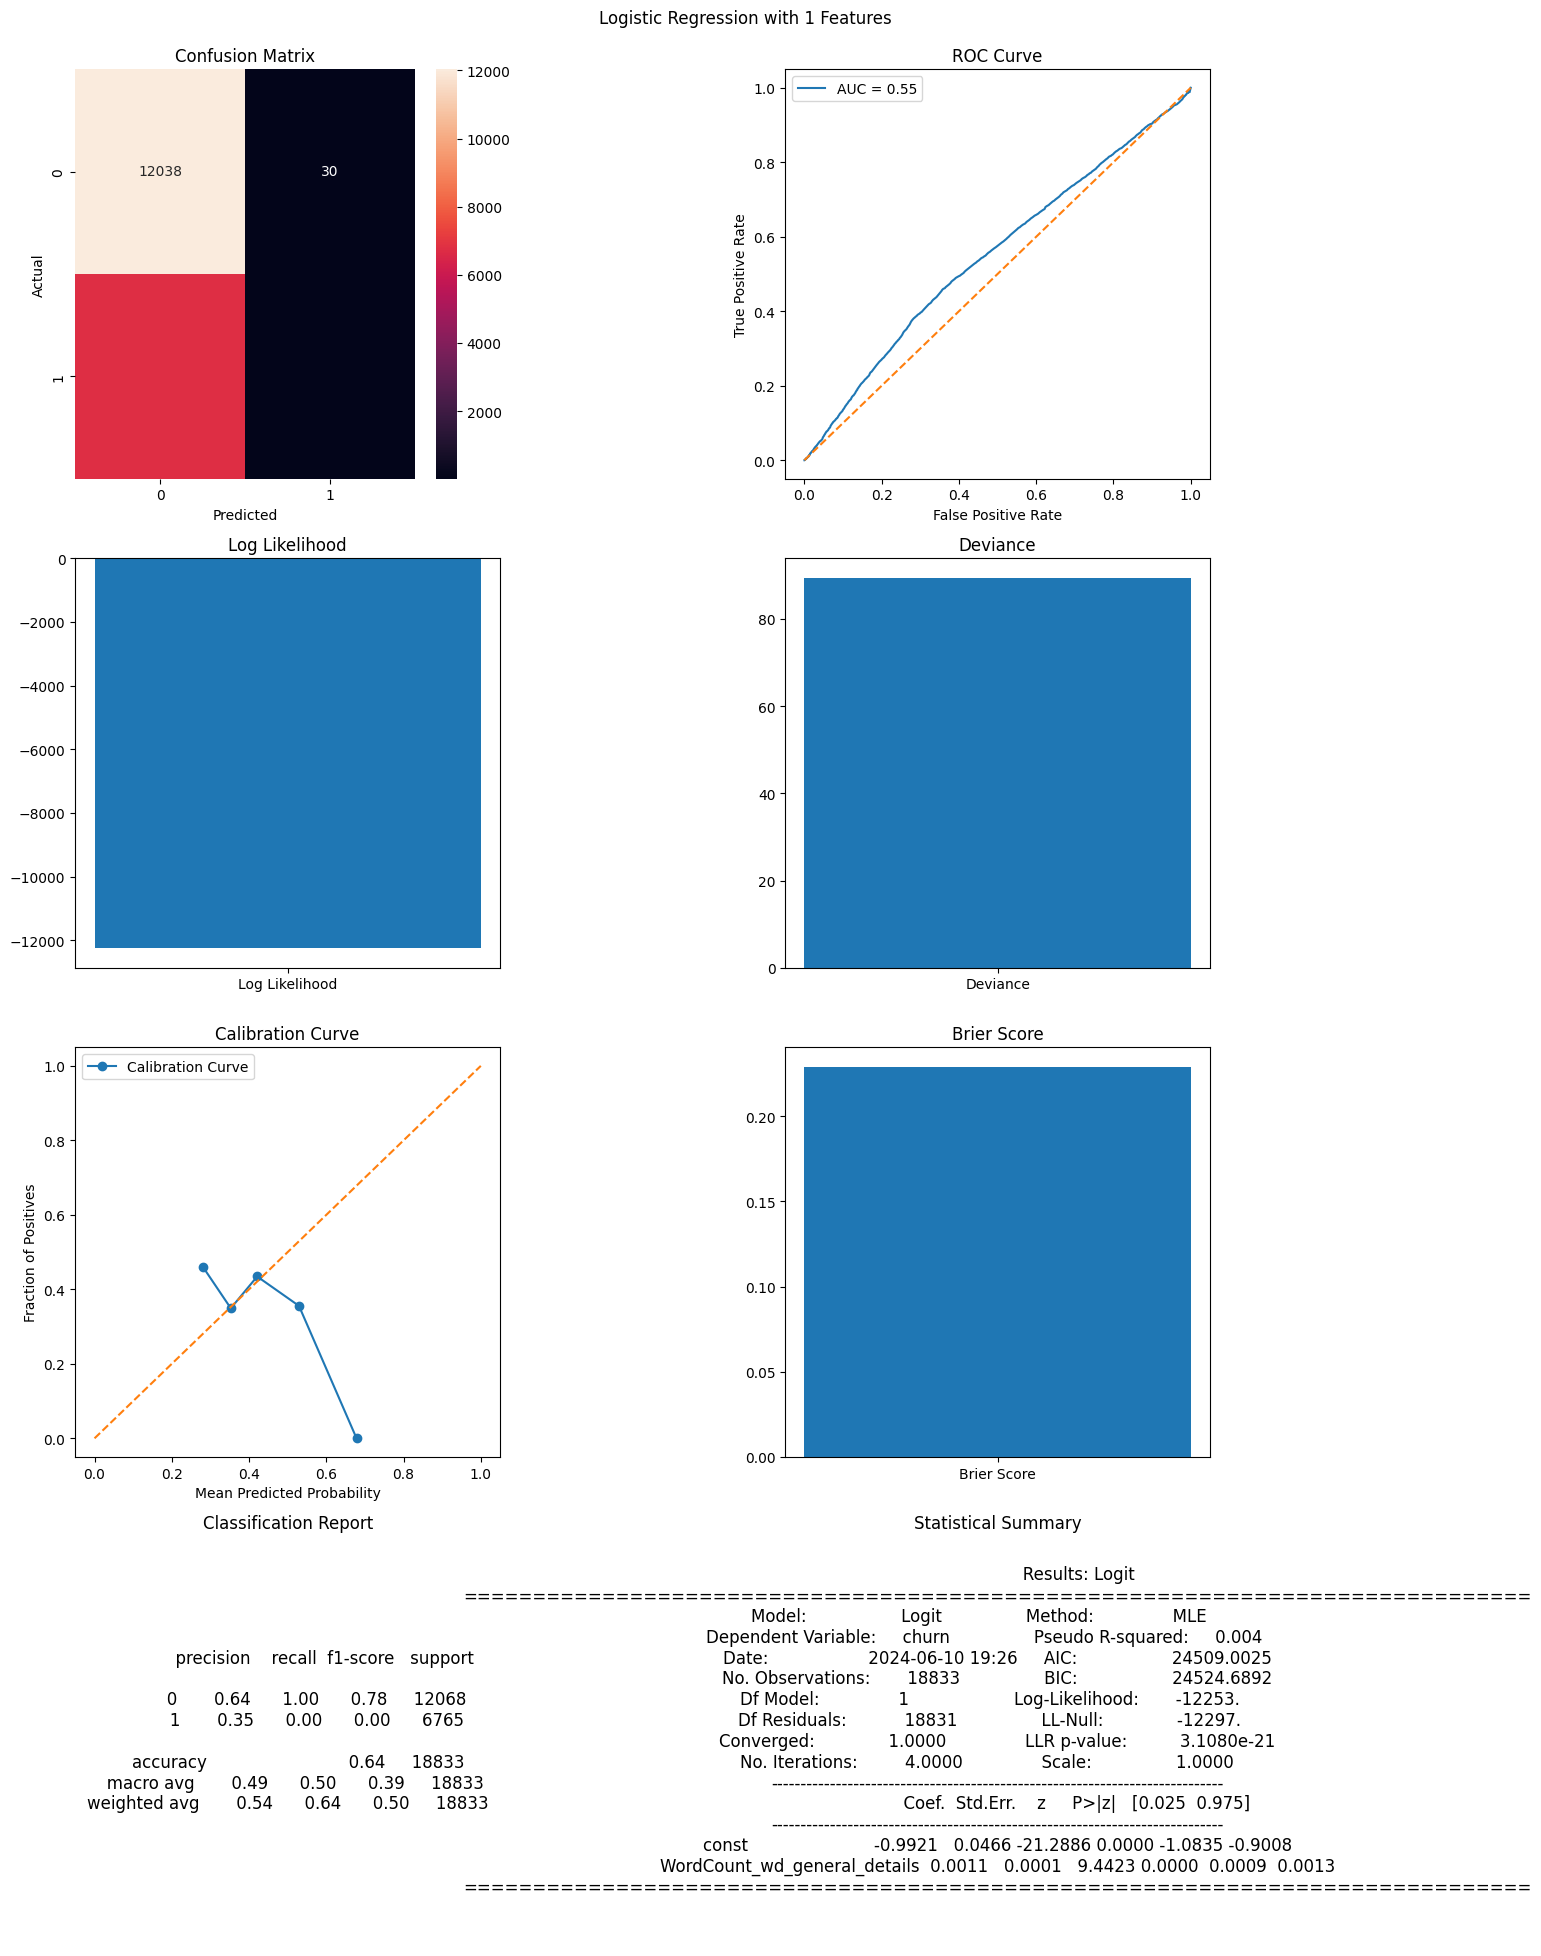

Analysis with 1 features:
Confusion Matrix:
[[12038    30]
 [ 6749    16]]
Interpretation: The confusion matrix shows the count of true positives, false positives, true negatives, and false negatives.

Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78     12068
           1       0.35      0.00      0.00      6765

    accuracy                           0.64     18833
   macro avg       0.49      0.50      0.39     18833
weighted avg       0.54      0.64      0.50     18833

Interpretation: The classification report provides precision, recall, f1-score, and support for each class.

AUC Score:
AUC: 0.55
Interpretation: AUC below 0.80 is generally considered not very good.

Brier Score:
Brier Score: 0.2291
Interpretation: Lower Brier Score indicates better predictions.

Log Likelihood:
Log Likelihood: -12252.50
Interpretation: Higher log likelihood indicates better fit of the model.

Deviance:
Deviance: 89.47
Interpr

{'features_1': {'confusion_matrix': array([[12038,    30],
         [ 6749,    16]], dtype=int64),
  'roc_curve': (array([0.00000000e+00, 8.28637720e-05, 3.31455088e-04, 3.31455088e-04,
          8.28637720e-04, 9.11501492e-04, 9.11501492e-04, 9.94365264e-04,
          1.07722904e-03, 1.16009281e-03, 1.16009281e-03, 1.32582035e-03,
          1.32582035e-03, 1.49154790e-03, 1.49154790e-03, 1.57441167e-03,
          1.65727544e-03, 1.74013921e-03, 2.07159430e-03, 2.07159430e-03,
          2.15445807e-03, 2.15445807e-03, 2.32018561e-03, 2.40304939e-03,
          2.40304939e-03, 2.48591316e-03, 2.48591316e-03, 2.65164070e-03,
          2.65164070e-03, 2.73450447e-03, 2.90023202e-03, 3.23168711e-03,
          3.23168711e-03, 3.39741465e-03, 3.39741465e-03, 3.56314219e-03,
          3.72886974e-03, 3.97746105e-03, 3.97746105e-03, 4.14318860e-03,
          4.14318860e-03, 4.39177991e-03, 4.39177991e-03, 4.39177991e-03,
          4.39177991e-03, 4.47464369e-03, 4.72323500e-03, 4.80609877e-03,


In [40]:
target = 'churn'  # Replace with the actual column name of your target variable
features = ['WordCount_wd_general_details']  # Replace with the actual column names of your features

# Call the logistic_regression_analysis function
results = logistic_regression_analysis(subset_property, target, features)
results

In [36]:
subset_property.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18833 entries, 0 to 18832
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   propertyid                       18833 non-null  int64  
 1   propertyreference                18833 non-null  int64  
 2   propertylivedate                 18833 non-null  object 
 3   DateToldWithdrawingLocal         6765 non-null   object 
 4   bedrooms                         18833 non-null  int64  
 5   propertyType                     18833 non-null  object 
 6   sleeps                           18830 non-null  float64
 7   location                         18831 non-null  object 
 8   churn                            18833 non-null  int64  
 9   valid_from                       18833 non-null  object 
 10  valid_to                         40 non-null     object 
 11  wd_general_details               18745 non-null  object 
 12  wd_ammenities_deta

### complexity

In [46]:
import pandas as pd
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import textstat

# Ensure necessary NLTK data files are downloaded
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Function to calculate text analysis metrics
def analyze_paragraph(df, column_name):
    # Initialize VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()
    
    # Function to calculate readability using textstat
    def calculate_readability(text):
        return textstat.flesch_kincaid_grade(text)
    
    # Function to calculate subjectivity and polarity using TextBlob
    def calculate_subjectivity_polarity(text):
        blob = TextBlob(text)
        subjectivity = blob.sentiment.subjectivity
        polarity = blob.sentiment.polarity
        return subjectivity, polarity
    
    # Function to calculate VADER sentiment scores
    def calculate_vader_sentiment(text):
        sentiment_scores = sia.polarity_scores(text)
        return sentiment_scores
    
    # Function to calculate keyword density
    def calculate_keyword_density(text):
        stop_words = set(stopwords.words('english'))
        words = [word for word in re.findall(r'\w+', text.lower()) if word not in stop_words]
        word_freq = Counter(words)
        total_words = sum(word_freq.values())
        keyword_density = {word: freq / total_words for word, freq in word_freq.items()}
        return keyword_density

    # Function to calculate uniqueness using TF-IDF
    def calculate_uniqueness(text_list):
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(text_list)
        uniqueness_scores = tfidf_matrix.mean(axis=1)
        return uniqueness_scores

    # Function to calculate engagement score
    def calculate_engagement(text):
        words = text.split()
        num_words = len(words)
        num_sentences = len(re.split(r'[.!?]+', text))
        avg_sentence_length = num_words / num_sentences if num_sentences else 0
        sentiment_scores = sia.polarity_scores(text)
        sentiment_compound = sentiment_scores['compound']
        
        # Engagement score based on a heuristic combining length, sentence complexity, and sentiment
        engagement_score = (num_words * avg_sentence_length * (1 + abs(sentiment_compound))) / 100
        return engagement_score

    # Ensure all entries in the column are treated as strings
    df[column_name] = df[column_name].astype(str)
    
    texts = df[column_name].tolist()
    uniqueness_scores = calculate_uniqueness(texts)
    
    results = []
    
    for i, text in enumerate(texts):
        readability = calculate_readability(text)
        subjectivity, polarity = calculate_subjectivity_polarity(text)
        sentiment_scores = calculate_vader_sentiment(text)
        keyword_density = calculate_keyword_density(text)
        engagement_score = calculate_engagement(text)
        uniqueness = uniqueness_scores[i, 0]
        
        result = {
            f"{column_name}_readability": readability,
            f"{column_name}_subjectivity": subjectivity,
            f"{column_name}_objectivity": 1 - subjectivity,
            f"{column_name}_emotion_polarity": polarity,
            f"{column_name}_sentiment": sentiment_scores,
            f"{column_name}_keyword_density": keyword_density,
            f"{column_name}_uniqueness": uniqueness,
            f"{column_name}_engagement_score": engagement_score
        }
        
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    # Merge the results with the original dataframe
    df = pd.concat([df, results_df], axis=1)
    return df

# Example usage
data = {
    "description": [
        "This charming holiday cottage offers a serene and comfortable retreat with stunning views of the countryside.",
        "Enjoy a relaxing vacation in this cozy and well-equipped holiday home located just a short walk from the beach."
    ]
}
df = pd.DataFrame(data)
result_df = analyze_paragraph(df, 'description')

result_df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DeepankarSrigyan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DeepankarSrigyan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,description,description_readability,description_subjectivity,description_objectivity,description_emotion_polarity,description_sentiment,description_keyword_density,description_uniqueness,description_engagement_score
0,This charming holiday cottage offers a serene ...,10.7,0.700000,0.300000,0.425000,"{'neg': 0.0, 'neu': 0.344, 'pos': 0.656, 'comp...","{'charming': 0.1, 'holiday': 0.1, 'cottage': 0...",0.132294,2.489728
1,Enjoy a relaxing vacation in this cozy and wel...,9.5,0.516667,0.483333,0.066667,"{'neg': 0.0, 'neu': 0.606, 'pos': 0.394, 'comp...","{'enjoy': 0.08333333333333333, 'relaxing': 0.0...",0.145111,3.328781


In [51]:
Property_Desc_v1 = analyze_paragraph(subset_property, 'wd_general_details')
Property_Desc = analyze_paragraph(Property_Desc_v1, 'wd_ammenities_details')
Property_Desc

C:\Users\DeepankarSrigyan\AppData\Local\Temp\ipykernel_5728\1383098155.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,propertyid,propertyreference,propertylivedate,DateToldWithdrawingLocal,bedrooms,propertyType,sleeps,location,churn,valid_from,valid_to,wd_general_details,wd_ammenities_details,WordCount_wd_general_details,WordCount_wd_ammenities_details,wd_general_details_readability,wd_general_details_subjectivity,wd_general_details_objectivity,wd_general_details_emotion_polarity,wd_general_details_sentiment,wd_general_details_keyword_density,wd_general_details_uniqueness,wd_general_details_engagement_score,wd_ammenities_details_readability,wd_ammenities_details_subjectivity,wd_ammenities_details_objectivity,wd_ammenities_details_emotion_polarity,wd_ammenities_details_sentiment,wd_ammenities_details_keyword_density,wd_ammenities_details_uniqueness,wd_ammenities_details_engagement_score
0,50037,2074,2023-05-09,None,3,Terraced,5.0,Pentre Hodre,0,2013-11-12,2033-11-12,A stunning barn conversion on the outskirts of...,"Electric oven & hob, microwave, fridge/freezer...",36,112,10.3,0.850000,0.150000,0.625000,"{'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'comp...","{'stunning': 0.041666666666666664, 'barn': 0.0...",0.000104,8.386416,5.6,0.530000,0.470000,-0.080000,"{'neg': 0.074, 'neu': 0.882, 'pos': 0.044, 'co...","{'electric': 0.022727272727272728, 'oven': 0.0...",0.000767,11.023667
1,127056,917853,2020-02-26,2023-01-25,3,House semi-detached,6.0,Craig-y-penrhyn,1,2016-09-13,None,Boasting a beautiful blue exterior and an equa...,Oil central heating and woodburning stove. Gas...,696,75,12.7,0.536338,0.463662,0.332200,"{'neg': 0.016, 'neu': 0.847, 'pos': 0.137, 'co...","{'boasting': 0.0025575447570332483, 'beautiful...",0.000311,403.296504,4.2,0.716667,0.283333,0.033333,"{'neg': 0.071, 'neu': 0.858, 'pos': 0.071, 'co...","{'oil': 0.018867924528301886, 'central': 0.018...",0.000600,5.408654
2,277826,917931,2024-04-24,None,2,House detached,4.0,Abererch,0,2016-09-13,None,"The Mill, nestled amidst the picturesque lands...","Oil central heating. Electric oven and hob, mi...",346,88,11.1,0.522194,0.477806,0.292857,"{'neg': 0.0, 'neu': 0.712, 'pos': 0.288, 'comp...","{'mill': 0.009852216748768473, 'nestled': 0.00...",0.000281,149.547731,3.8,0.573214,0.426786,0.028571,"{'neg': 0.038, 'neu': 0.855, 'pos': 0.107, 'co...","{'oil': 0.013888888888888888, 'central': 0.013...",0.000664,7.974498
3,51456,3888,2024-03-19,None,2,House detached,5.0,Moneystone,0,2013-11-12,2033-11-12,Oakamoor 1 mile. Barks Cottage is nestled in t...,"LPG central heating. Electric oven and hob, mi...",467,139,14.0,0.573640,0.426360,0.321212,"{'neg': 0.004, 'neu': 0.744, 'pos': 0.251, 'co...","{'oakamoor': 0.0070921985815602835, '1': 0.003...",0.000287,242.199951,5.5,0.497500,0.502500,0.190000,"{'neg': 0.056, 'neu': 0.867, 'pos': 0.077, 'co...","{'lpg': 0.00980392156862745, 'central': 0.0098...",0.000837,15.813272
4,71687,918526,2021-11-01,None,3,Semi detached,6.0,St Lawrence,0,2016-03-08,2033-03-08,Swifts is the larger of the two semi-detached ...,"Electric panel heaters. Electric oven and hob,...",113,114,9.7,0.404847,0.595153,0.185204,"{'neg': 0.0, 'neu': 0.965, 'pos': 0.035, 'comp...","{'swifts': 0.013513513513513514, 'larger': 0.0...",0.000174,34.580580,3.9,0.536905,0.463095,0.132143,"{'neg': 0.08, 'neu': 0.881, 'pos': 0.039, 'com...","{'electric': 0.024691358024691357, 'panel': 0....",0.000775,9.723060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18828,286356,1157742,2024-05-21,None,2,Annex,3.0,Fishguard/Abergwaun,0,2024-05-20,None,"Harbour High Annex, a characterful cottage, is...","Gas central heating. Electric oven and hob, mi...",305,102,12.0,0.509756,0.490244,0.231110,"{'neg': 0.0, 'neu': 0.788, 'pos': 0.212, 'comp...","{'harbour': 0.021739130434782608, 'high': 0.01...",0.000224,142.879244,3.4,0.591429,0.408571,0.037857,"{'neg': 0.052, 'neu': 0.868, 'pos': 0.079, 'co...","{'gas': 0.012195121951219513, 'central': 0.012...",0.000722,8.320079
18829,286452,1157788,2024-05-25,None,3,House semi-detached,6

In [54]:
Property_Desc.to_excel('Property_Desc.xlsx')